# Creation of our own model

In [1]:
from carRecognition import display_bounding_boxes

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# from PIL import Image
import torchvision.transforms as transforms
import pandas as pd

import cv2
torch.manual_seed(2)

# https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data

In [2]:
# Global variables

NEW_WIDTH = 338
NEW_HEIGHT = 190

# NEW_HEIGHT = 190
# NEW_WIDTH = 338

# cv2     : [height, width, c]
# pytorch : [channels, height, width]

In [3]:
class CarRecognitionDataset(Dataset):
    def __init__(self, images_dir, csv_annotations, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(csv_annotations)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # enough to have 1 channel...
        image = image[:,:,:3] # removing alpha cannal if it exists
        # must be (c, height, width)
        # note : trasnform.ToTensor() does the permute() alone
        y = torch.tensor(self.annotations.iloc[index, 1:5]) # 1:5 for bounding box coord
        y = y/2 # change to ratio

        image = self.transform(image) # transform has to resize


        return image, y

In [4]:
def iou_bboxes(outputs: torch.Tensor, labels: torch.Tensor, smooth=1e-6):
    # outputs et labels sont supposés être de forme [batch_size, 4] avec 4 pour les coordonnées [x_min, y_min, x_max, y_max]
    
    # Calcul des coordonnées de l'intersection
    x1 = torch.max(outputs[:, 0], labels[:, 0])
    y1 = torch.max(outputs[:, 1], labels[:, 1])
    x2 = torch.min(outputs[:, 2], labels[:, 2])
    y2 = torch.min(outputs[:, 3], labels[:, 3])
    
    # Calcul de l'aire de l'intersection
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    
    # Calcul de l'aire de chaque boîte
    area_output = (outputs[:, 2] - outputs[:, 0]) * (outputs[:, 3] - outputs[:, 1])
    area_label = (labels[:, 2] - labels[:, 0]) * (labels[:, 3] - labels[:, 1])
    
    # Calcul de l'aire de l'union
    union = area_output + area_label - intersection + smooth  # Ajout de smooth pour éviter la division par zéro
    
    # Calcul de l'IoU
    iou = (intersection + smooth) / union
    return iou.mean()  # Retourne l'IoU moyen pour le batch

In [5]:
dataset = CarRecognitionDataset(csv_annotations='data/train_boxes.csv', images_dir='data/train/',
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize((NEW_HEIGHT, NEW_WIDTH))
                                 ]))

In [6]:
train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

In [7]:
def train(model, criterion, train_loader, test_loader, optimizer, epochs=10):
    i = 0
    output = {'training_loss': [], 'test_accuracy': []}  
    
    for epoch in range(epochs):
        print(str(epoch) + " / " + str(epochs))
        for i, (image, box) in enumerate(train_loader):
            image=image.float()
            box=box.float()
            optimizer.zero_grad()
            z = model(image)
            loss = criterion(z, box)
            loss.backward()
            optimizer.step()
            output['training_loss'].append(loss.data.item())
    
    return output

In [8]:
sobel3_verti = torch.tensor([[-1., -2., -1.],
                             [0., 0., 0.],
                             [1., 2., 1.]]) # "vertical", Sobel filter, from top to bottom
# aa = sobel3_verti * -1
sobel3_horiz = torch.transpose(sobel3_verti, 0, 1)

class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.sobel_verti = sobel3_verti.view(1, 1, 3, 3).repeat(3, 1, 1, 1)
        self.sobel_horiz = sobel3_horiz.view(1, 1, 3, 3).repeat(3, 1, 1, 1)

    def forward(self, x, threshold = 1.0):
        sob_vert = F.conv2d(x, self.sobel_verti, groups=3)
        sob_hori = F.conv2d(x, self.sobel_horiz, groups=3)
        vert_sq = torch.mul(sob_vert, sob_vert)
        hori_sq = torch.mul(sob_hori, sob_hori)
        filtered = torch.sqrt( torch.add( vert_sq, hori_sq ) ) # sqrt(verti² + horiz²)

        thresholded = torch.where(filtered < threshold, torch.tensor(0.0), filtered)
        return thresholded
        

# model = Sobel()
# a = model(img, 1.6)
# plt.imshow(a.permute(1,2,0))

In [9]:
## ONGOING CAR DETECTION MODEL NOVEMBER 3rd 2024
# output_size = (in_size - kernel_size + (2*padding))/stride   + 1
class SobelCarNet(nn.Module):
    def __init__(self, in_size=0, threshold = 0.5):
        super(SobelCarNet, self).__init__()
        self.threshold = threshold
        self.dynamic_input = 39*20*64 # size * conv1 output

        self.sobel = Sobel()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=0) # size - kernel_size + 1 + (2*padding)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # augmenter, genre 3

        self.conv2 = nn.Conv2d(16, 64, kernel_size=11, stride=2, padding=0) # check dim
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # check dim

        self.fc1 = nn.Linear(self.dynamic_input, 128) # check dim
        self.fc2 = nn.Linear(128, 4)

    def forward(self, img):


        x = F.relu(self.sobel(img, self.threshold))
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, self.dynamic_input)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

In [10]:
## ONGOING CAR DETECTION MODEL NOVEMBER 3rd 2024
# output_size = (in_size - kernel_size + (2*padding))/stride   + 1
class CarNet(nn.Module):
    def __init__(self):
        super(CarNet, self).__init__()
        # 338, 190
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0), # to get edge detectors
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        )
        # 84, 47
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=0), # stride=2 ?
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 40, 21
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), # padding=(height, width)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 19, 9 
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        # 17, 7
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(17*7*128, 8192),
            nn.ReLU()
        )
        #
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4),
            nn.ReLU()
        )

    def forward(self, img):

        out = self.layer1(img)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    

In [11]:
## ONGOING CAR DETECTION MODEL NOVEMBER 3rd 2024
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.dynamic_input = 256*4*9 # size * conv1 output

        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(self.dynamic_input, 4096)
        self.fc2 = nn.Linear(4096, 4)

    def forward(self, img):
        out = self.conv1(img)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.pool3(out)
        # print(out.shape) # torch.Size([32, 256, 4, 9])
        out = out.view(-1, 9216)

        out = self.fc1(out)
        out = self.fc2(out)
        return out

    
# shape '[-1, 505344]' is invalid for input of size 7951872

In [13]:
import torch.optim as optim

# images INITIAL shape : 676 x 380

learning_rate = 0.0005
epochs = 150
# model = CarNet(1, threshold=1.0)
model = CarNet()

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

output=train(model, criterion, train_loader, val_loader, optimizer, epochs)

# TRY TO VISUALIZE THE LOSS OVER EPOCH
# ALSO : IoU for train and test


0 / 150
1 / 150
2 / 150
3 / 150
4 / 150
5 / 150
6 / 150
7 / 150
8 / 150
9 / 150
10 / 150
11 / 150
12 / 150
13 / 150
14 / 150
15 / 150
16 / 150
17 / 150
18 / 150
19 / 150
20 / 150
21 / 150
22 / 150
23 / 150
24 / 150
25 / 150
26 / 150
27 / 150
28 / 150
29 / 150
30 / 150
31 / 150
32 / 150
33 / 150
34 / 150
35 / 150
36 / 150
37 / 150
38 / 150
39 / 150
40 / 150
41 / 150
42 / 150
43 / 150
44 / 150
45 / 150
46 / 150
47 / 150
48 / 150
49 / 150
50 / 150
51 / 150
52 / 150
53 / 150
54 / 150
55 / 150
56 / 150
57 / 150
58 / 150
59 / 150
60 / 150
61 / 150
62 / 150
63 / 150
64 / 150
65 / 150
66 / 150
67 / 150
68 / 150
69 / 150
70 / 150
71 / 150
72 / 150
73 / 150
74 / 150
75 / 150
76 / 150
77 / 150
78 / 150
79 / 150
80 / 150
81 / 150
82 / 150
83 / 150
84 / 150
85 / 150
86 / 150
87 / 150
88 / 150
89 / 150
90 / 150
91 / 150
92 / 150
93 / 150
94 / 150
95 / 150
96 / 150
97 / 150
98 / 150
99 / 150
100 / 150
101 / 150
102 / 150
103 / 150
104 / 150
105 / 150
106 / 150
107 / 150
108 / 150
109 / 150
110 / 150


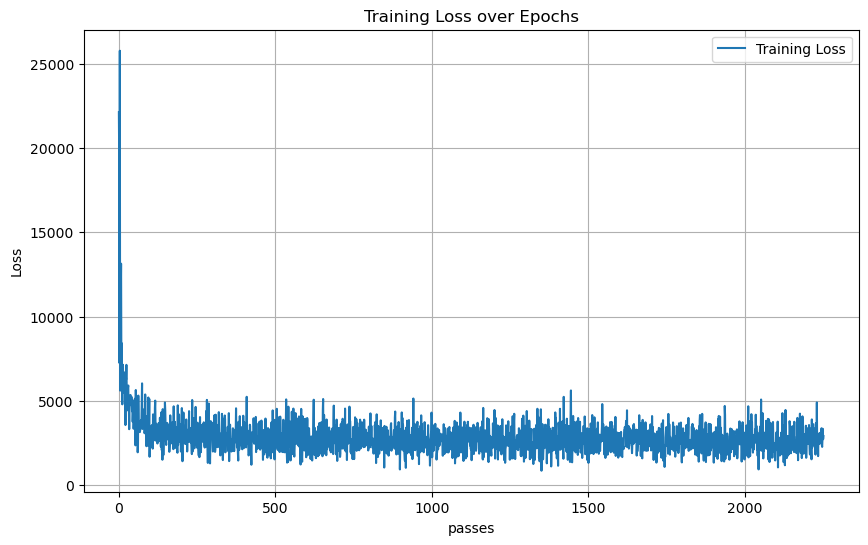

In [ ]:
training_loss = output['training_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.xlabel('passes')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model.eval()
total_iou = 0.0
num_batches = 0
transform = transforms.Compose([transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])

with torch.no_grad():
    for images, labels in val_loader:

        img = transform(images)
        predictions = model(img)
        # predictions = pred.numpy()
        
        # Calcul de l'exactitude (accuracy)
        # _, predicted = torch.max(predictions, 1)
        # correct += (predicted == labels).sum().item()
        
        # Calcul de l'IoU pour le batch
        batch_iou = iou_bboxes(predictions, labels)
        total_iou += batch_iou.item()
        num_batches += 1

mean_iou = total_iou / num_batches
print(f"Validation IoU: {mean_iou}")


Validation IoU: 0.10970797398836876


In [16]:
model.eval()
total_iou = 0.0
num_batches = 0
transform = transforms.Compose([transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])

with torch.no_grad():
    for images, labels in train_loader:

        img = transform(images)
        predictions = model(img)
        # predictions = pred.numpy()
        
        # Calcul de l'exactitude (accuracy)
        # _, predicted = torch.max(predictions, 1)
        # correct += (predicted == labels).sum().item()
        
        # Calcul de l'IoU pour le batch
        batch_iou = iou_bboxes(predictions, labels)
        total_iou += batch_iou.item()
        num_batches += 1

mean_iou = total_iou / num_batches
print(f"Training IoU: {mean_iou}")


Training IoU: 0.1315810911479974


done
torch.Size([3, 190, 338])


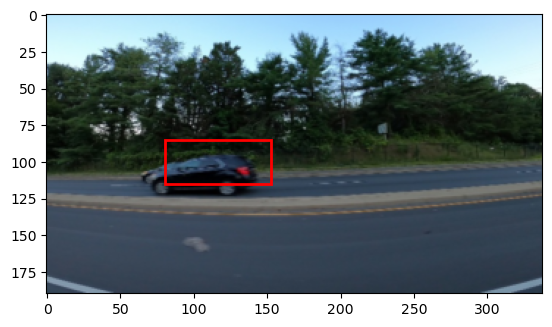

torch.Size([3, 190, 338])


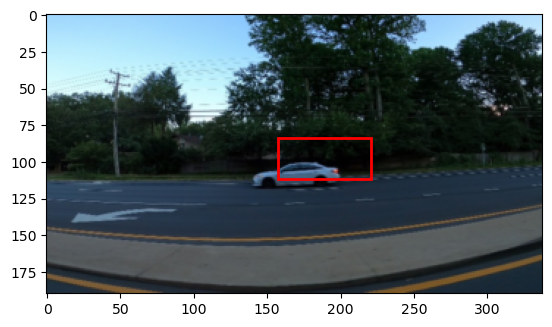

torch.Size([3, 190, 338])


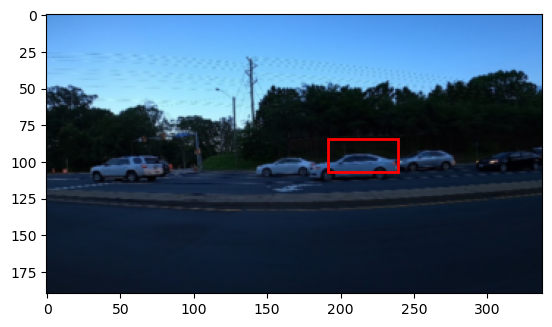

torch.Size([3, 190, 338])


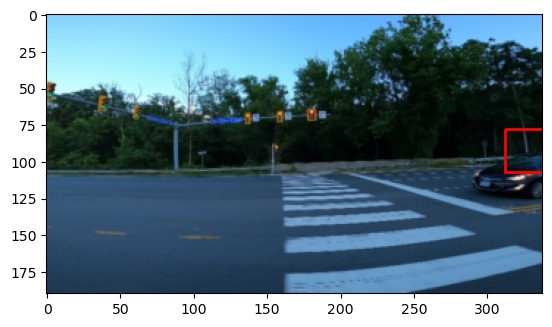

torch.Size([3, 190, 338])


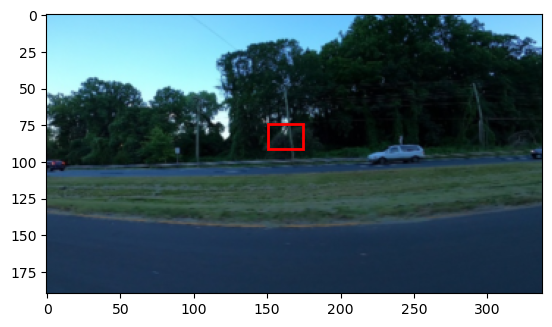

In [ ]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

img_list = []
for img, label in train_loader:
    img_list = img[:5]

for img in img_list :
    img = img.unsqueeze(0)
    pred = model(img)
    img = img.squeeze(0)
    display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

done
torch.Size([3, 190, 338])


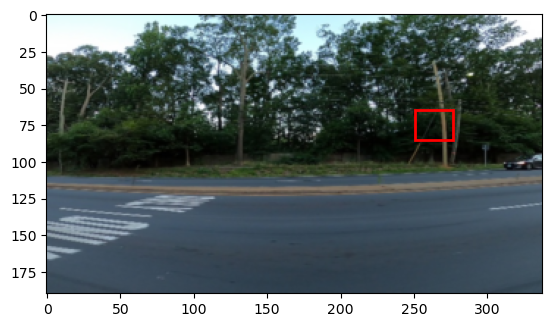

torch.Size([3, 190, 338])


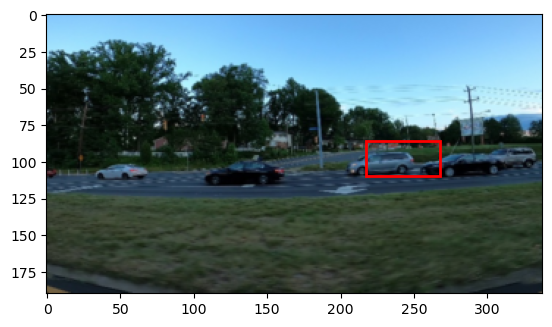

torch.Size([3, 190, 338])


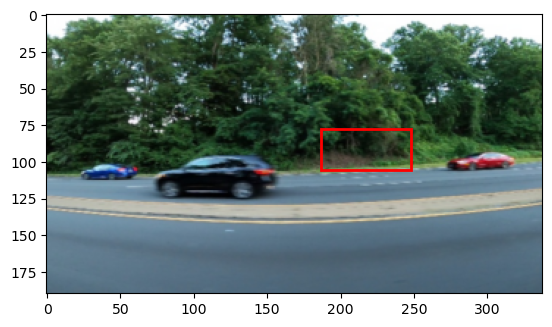

torch.Size([3, 190, 338])


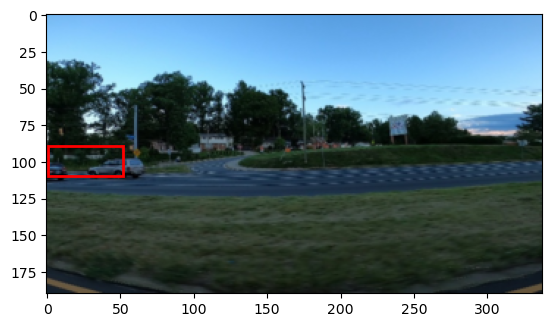

torch.Size([3, 190, 338])


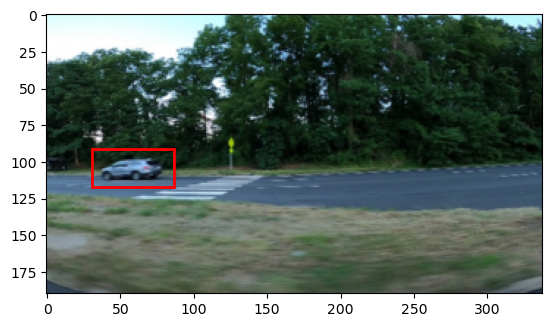

In [18]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

img_list = []
for img, label in val_loader:
    img_list = img[:5]

for img in img_list :
    img = img.unsqueeze(0)
    pred = model(img)
    img = img.squeeze(0)
    print(img.shape)
    display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

## MAKING SOBEL CLASS WORK

In [ ]:
sobel3_verti = torch.tensor([[-1., -2., -1.],
                             [0., 0., 0.],
                             [1., 2., 1.]]) # "vertical", Sobel filter, from top to bottom
# aa = sobel3_verti * -1
sobel3_horiz = torch.transpose(sobel3_verti, 0, 1)

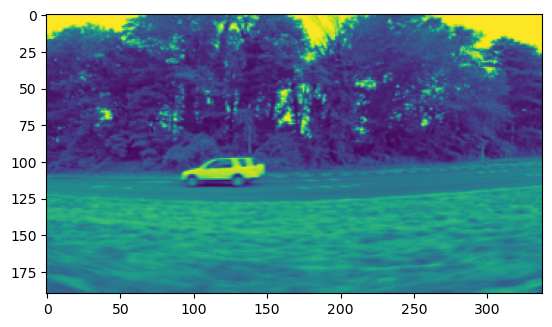

In [12]:
image_path = 'data/train/vid_4_3140.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display

#image = image[:,:,:]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)
plt.imshow(img.permute(1,2,0))

In [51]:
img.shape

torch.Size([1, 190, 338])

In [14]:
class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.sobel_verti = sobel3_verti.view(1, 1, 3, 3)
        self.sobel_horiz = sobel3_horiz.view(1, 1, 3, 3)

    def forward(self, x, threshold = 0.5):
        sob_vert = F.conv2d(x, self.sobel_verti, groups=1)
        sob_hori = F.conv2d(x, self.sobel_horiz, groups=1)
        vert_sq = torch.mul(sob_vert, sob_vert)
        hori_sq = torch.mul(sob_hori, sob_hori)
        filtered = torch.sqrt( torch.add( vert_sq, hori_sq ) ) # sqrt(verti² + horiz²)

        thresholded = torch.where(filtered < threshold, torch.tensor(0.0), filtered)
        return thresholded
        

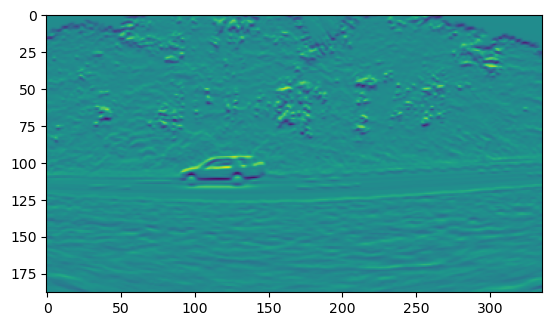

In [13]:
# controled conv1
nb_channels = 1

weights = sobel3_verti.view(1, 1, 3, 3)#.repeat(nb_channels, 1, 1, 1)
Gx = F.conv2d(img, weights, groups=1)
plt.imshow(Gx.permute(1,2,0))




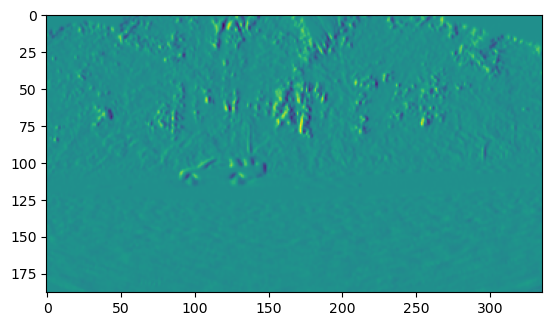

In [14]:
weights = sobel3_horiz.view(1, 1, 3, 3)#.repeat(nb_channels, 1, 1, 1)
Gy = F.conv2d(img, weights, groups=1)
plt.imshow(Gy.permute(1,2,0))


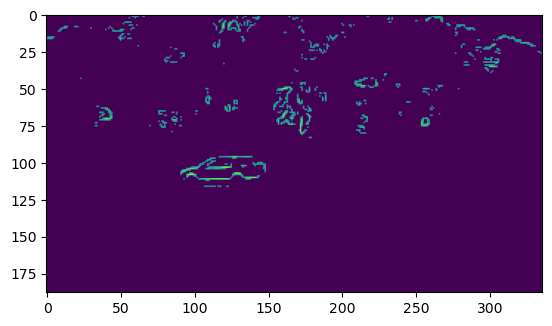

In [15]:
model = Sobel()
a = model(img, 1.6)
plt.imshow(a.permute(1,2,0))

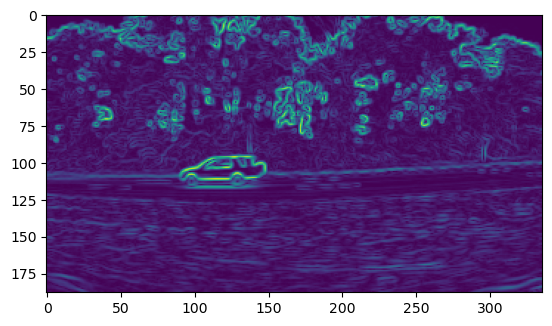

In [86]:
finx = torch.mul(Gx, Gx)
finy = torch.mul(Gy, Gy)
s = torch.add(finx, finy)
fin = torch.sqrt(s)
plt.imshow(fin.permute(1,2,0))

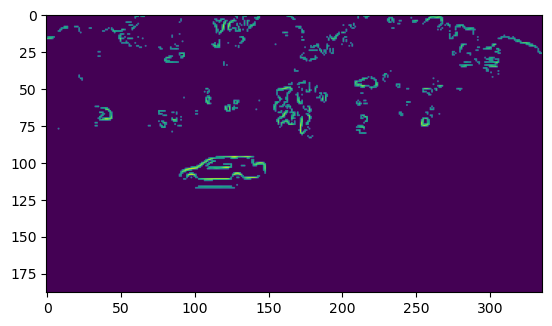

In [87]:
# do the threshold
shape = fin.shape
flat = fin.flatten()
threshold = 1.6

for i in range(len(flat)):
    if flat[i] < threshold : flat[i] = 0

param = flat.view(shape)
plt.imshow(param.permute(1,2,0))

## END SOBEL CLASS

## HANDS-ON MODEL MANIP

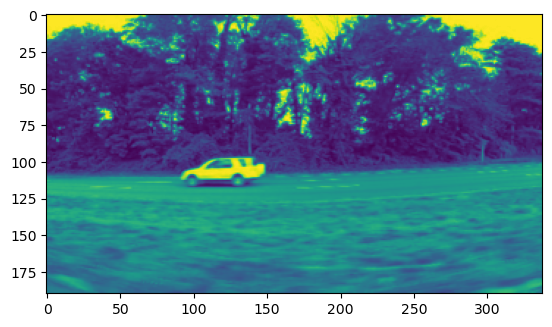

In [11]:
image_path = 'data/train/vid_4_3140.jpg'
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
image = image[:,:,0]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)
plt.imshow(img.permute(1,2,0))

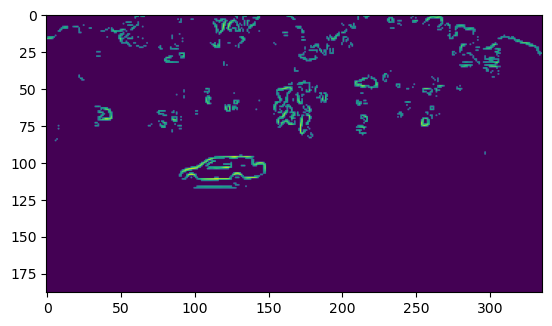

In [12]:
model = Sobel()
mod = model(img, threshold=1.5)
plt.imshow(mod.permute(1,2,0))

In [178]:
conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
x = conv1(mod)

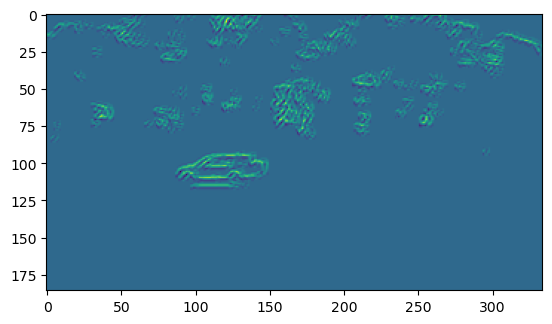

In [179]:
plt.imshow(x.detach().permute(1,2, 0).numpy()[:,:,0])

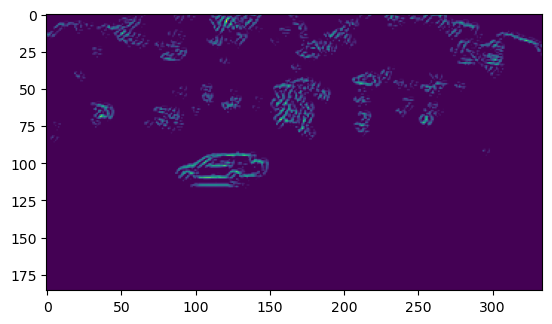

In [180]:
tik = F.relu(x)
plt.imshow(tik.detach().permute(1,2, 0).numpy()[:,:,0])

In [181]:
pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
tok = pool1(tik)

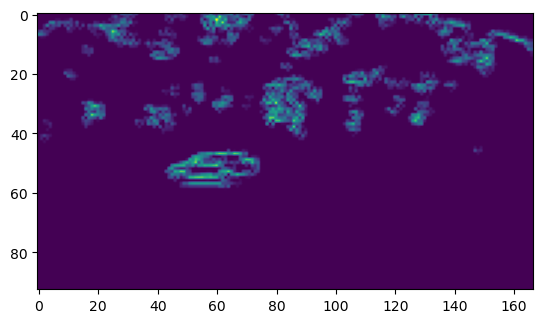

In [182]:
plt.imshow(tok.detach().permute(1,2, 0).numpy()[:,:,0])